[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roedersen/keras-OpenSlideGenerator/blob/master/capstone_camyleon.ipynb)

In [ ]:
!pip install tripy

In [ ]:
!pip install pyclipper

In [ ]:
!apt-get install openslide-tools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
!pip install openslide-python

In [ ]:
!git clone https://github.com/roedersen/keras-OpenSlideGenerator

fatal: destination path 'keras-OpenSlideGenerator' already exists and is not an empty directory.


In [ ]:
from __future__ import print_function
from matplotlib import cm
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
import os
import math
import random
import copy
import numpy as np
import cv2
import tripy
import pyclipper
from openslide import OpenSlide
from skimage.color import rgb2hed, hed2rgb
import time
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
labels = '/content/drive/MyDrive/Dokumente/FourthBrain/capstone/data/labels/'
images = '/tmp/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/keras-OpenSlideGenerator")
import openslide_generator

In [ ]:
!cp /content/drive/MyDrive/CAMELYON17/training/center_1/patient_038.zip /tmp
!unzip /tmp/patient_038.zip -d /tmp/center_1/

^C
Archive:  /tmp/patient_038.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /tmp/patient_038.zip or
        /tmp/patient_038.zip.zip, and cannot find /tmp/patient_038.zip.ZIP, period.


In [ ]:
!cp /content/drive/MyDrive/CAMELYON17/training/center_4/patient_080.zip /tmp
!unzip /tmp/patient_080.zip -d /tmp/center_4/

^C
Archive:  /tmp/patient_080.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /tmp/patient_080.zip or
        /tmp/patient_080.zip.zip, and cannot find /tmp/patient_080.zip.ZIP, period.


In [ ]:
# create generator instance
gen_train = openslide_generator.OpenSlideGenerator(labels + 'labels_train.txt', \
                                                   images, 512, 256, \
                                                   fetch_mode='label-slide', \
                                                   label_to_use=0)
print("gen_train defined")

loaded 5 slide(s).
[0] center_1/patient_038_node_0.tif
- 2 regions
- 1270578851.6684685 px2
- patch scale: 512
- fetch probability (area mode): 0.076421725058859
[1] center_1/patient_038_node_1.tif
- 2 regions
- 4922005609.388678 px2
- patch scale: 512
- fetch probability (area mode): 0.3012671798861856
[2] center_1/patient_038_node_2.tif
- 11 regions
- 1808509137.469384 px2
- patch scale: 512
- fetch probability (area mode): 0.10820207174354116
[3] center_1/patient_038_node_3.tif
- 3 regions
- 7344859921.665641 px2
- patch scale: 512
- fetch probability (area mode): 0.44983313246295664
[4] center_1/patient_038_node_4.tif
- 4 regions
- 1101264861.114746 px2
- patch scale: 512
- fetch probability (area mode): 0.06427589084845738
there are total 22 regions.
patches per epoch is set to 62737.

gen_train defined


In [ ]:
gen_val = openslide_generator.OpenSlideGenerator(labels + 'labels_val.txt', \
                                                 images, 512, 256, \
                                                 fetch_mode='label-slide', \
                                                 label_to_use=0)
print("gen_val defined")

loaded 1 slide(s).
[0] center_4/patient_080_node_1.tif
- 14 regions
- 4140589142.13493 px2
- patch scale: 512
- fetch probability (area mode): 1.0000000000000013
there are total 14 regions.
patches per epoch is set to 15795.

gen_val defined


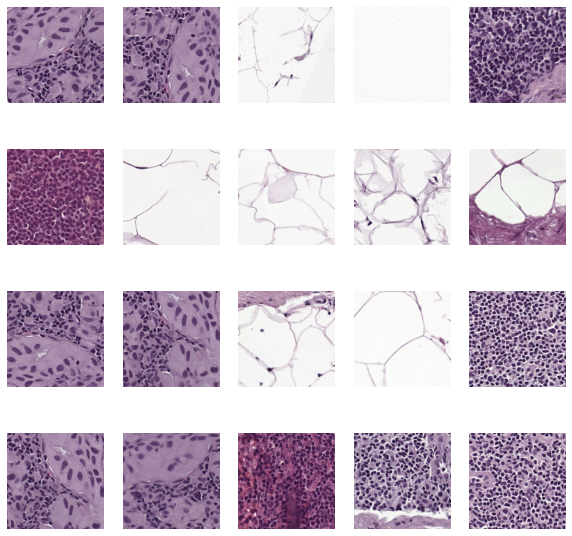

In [ ]:
plt.figure(figsize=(10,10))
for i in range(20):
    image, label, (slide_id, region_id, posx, posy) = gen_train.get_example(i)
    #print(image.shape)
    plt.subplot(4,5,i+1)
    plt.imshow(image.transpose(1,2,0))
    plt.axis('off')

In [ ]:
batch_size = 32
num_classes = len(gen_train.labels[gen_train.label_to_use])
epochs = 3
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_openslide_trained_model.h5'
t_steps = math.ceil(gen_train.patch_per_epoch/batch_size)
v_steps = math.ceil(gen_val.patch_per_epoch/batch_size)

In [ ]:
# model construction
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=gen_train.shape()))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
# Fit the model on the batches generated by datagen.flow()
training_history = model.fit(gen_train.flow(batch_size=batch_size), \
                             steps_per_epoch=t_steps, \
                             epochs=epochs, \
                             validation_data=gen_val.flow(batch_size=batch_size), 
                             validation_steps=v_steps, \
                             workers=4, \
                             use_multiprocessing=True, \
                             verbose=1)

Epoch 1/3
1961/1961 [==============================] - 826s 419ms/step - loss: 0.0907 - accuracy: 0.9767 - val_loss: 3.8600 - val_accuracy: 0.2182
Epoch 2/3
1961/1961 [==============================] - 823s 420ms/step - loss: 0.0277 - accuracy: 0.9951 - val_loss: 5.8827 - val_accuracy: 0.0514
Epoch 3/3
1961/1961 [==============================] - 820s 418ms/step - loss: 0.0185 - accuracy: 0.9966 - val_loss: 4.8825 - val_accuracy: 0.1036


In [ ]:
now = datetime.now()
model.save('/content/drive/MyDrive/Dokumente/FourthBrain/capstone/model/model_' + str(now.strftime("%Y%m%d_%H%M")),save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dokumente/FourthBrain/capstone/model/model_20220503_0545/assets


In [ ]:
def plot_loss_history(training_history, logscale=False):
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.show()

    
def plot_accuracy_history(training_history):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='green', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

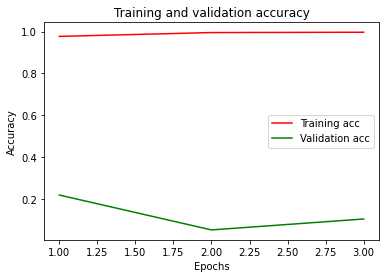

In [ ]:
plot_accuracy_history(training_history.history)

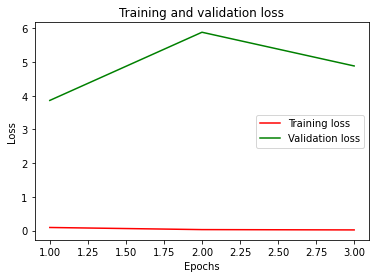

In [ ]:
plot_loss_history(training_history.history)

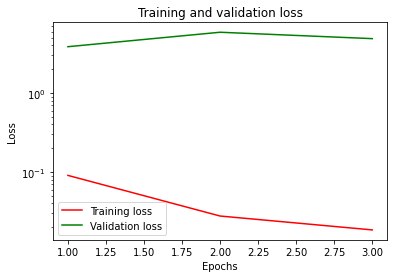

In [ ]:
plot_loss_history(training_history.history, logscale=True)